In [62]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [63]:
class taxi_rl:
    def __init__(self, parameters):
        # self.env = gym.make("Taxi-v3", render_mode="rgb_array")
        # self.env = gym.make("Taxi-v3", render_mode="human")
        # self.env = gym.make("Taxi-v3", render_mode="ansi")
        self.env = gym.make("Taxi-v3")

        self.gamma = parameters["gamma"]
        self.theta = parameters["theta"]
        self.n_states = self.env.observation_space.n
        self.n_actions = self.env.action_space.n

        print("Número de estados:", self.n_states)
        print("Número de ações:", self.n_actions)

        self.env.reset()
        
        self.policy = (1.0 / self.n_actions) * np.ones((self.n_states, self.n_actions))
        self.deterministic_policy = np.random.choice(self.n_actions, self.n_states)        
        self.value = np.zeros(self.n_states)
        self.q_sa = np.zeros((self.n_states, self.n_actions))

        # logs para plot
        self.eval_deltas = []   # List[List[Δ]] por iter de política
        self.value_progression = []   # List[mean(V)] por iter de política
        
    def reset_env(self):
        # self.env.reset()
        self.env.reset(seed=42)[0]
        
    def render(self):
        # return self.env.render()
        print(self.env.render())

In [64]:
class taxi_rl(taxi_rl):
    def bellmanEquation(self, s):
        v = 0.0

        for a in range(self.n_actions):
            pi = self.policy[s][a]
            
            transitions = self.env.P[s][a]
            for prob, sl, r, _ in transitions:
                v += pi * prob * (r + self.gamma * self.value[sl])
        return v

In [65]:
class taxi_rl(taxi_rl):
    def run_episodes(self):
        self.env = gym.make("Taxi-v3", render_mode="human")
        self.env.reset()
        state = self.env.s
        done = False
        step = 0

        while not done:
            action = np.argmax(self.policy[state])
            next_state, reward, done, truncate, info = self.env.step(action)
            print(f"Step {step}: State={state}, Action={action}, Reward={reward}, Next State={next_state}")
            state = next_state
            step += 1

            if step >= 500:
                break

        print(f"finished after {step} steps.\n")

        return step


In [66]:
class taxi_rl(taxi_rl):
    def policy_evaluation(self):
        delta = float("inf")
        n_steps = 0
        deltas = []
        while delta > self.theta:
            n_steps += 1
            delta = 0.0
            for s in range(self.n_states):
                v = self.value[s]
                self.value[s] = sum(
                    self.policy[s][a] * sum(
                        prob * (r + self.gamma * self.value[sl])
                        for prob, sl, r, _ in self.env.P[s][a]
                    )
                    for a in range(self.n_actions)
                )
                delta = max(delta, abs(v - self.value[s]))
            deltas.append(delta)
        return deltas

    def policy_improvement(self):
        policy_stable = True
        for s in range(self.n_states):
            old_action = np.argmax(self.policy[s])
            action_values = np.zeros(self.n_actions)
            for a in range(self.n_actions):
                action_values[a] = sum(
                    prob * (r + self.gamma * self.value[sl])
                    for prob, sl, r, _ in self.env.P[s][a]
                )
            best_action = np.argmax(action_values)
            if old_action != best_action:
                policy_stable = False
            self.policy[s] = np.zeros(self.n_actions)
            self.policy[s][best_action] = 1.0
        self.value_progression.append(np.mean(self.value))
        return policy_stable
    
    def evaluate_return(self):
        """Roda self.eval_episodes episódios usando a política atual e retorna a média de retorno."""
        returns = []
        for ep in range(self.eval_episodes):
            obs = self.env.reset(seed=ep)[0]
            done = False
            total = 0
            while not done:
                a, = np.where(self.policy[obs] == 1.0)
                obs, r, done, _, _ = self.env.step(int(a))
                total += r
            returns.append(total)
        self.iteration_returns.append(np.mean(returns))
        return np.mean(returns)

In [67]:
class taxi_rl(taxi_rl):
    def plot_reward(self):
        # Após convergir a política:
        n_episodes = 500
        episode_rewards = np.zeros(n_episodes)

        for ep in range(n_episodes):
            state, _ = taxi.env.reset(seed=ep)
            done = False
            total_r = 0
            while not done:
                # ação greedy
                action = np.argmax(taxi.policy[state])
                state, r, done, _, _ = taxi.env.step(action)
                total_r += r
            episode_rewards[ep] = total_r

        # plotando a curva de recompensa
        plt.figure()
        plt.plot(range(n_episodes), episode_rewards)
        plt.xlabel("Episódio")
        plt.ylabel("Recompensa total")
        plt.title("Evolução da recompensa com Policy Iteration")
        plt.show()

In [68]:
class taxi_rl(taxi_rl):
    def plot_policy_iteration_progress(self, eval_deltas, value_progression):
        """Plota (1) Δ vs sweeps, para cada iter de política, e (2) mean(V) vs iter."""
        # 1) Convergência de policy evaluation
        plt.figure(figsize=(8, 4))
        for it, deltas in enumerate(eval_deltas, start=1):
            plt.plot(deltas, label=f"iteração {it}")
        plt.xlabel("Passo da Avaliação de Política")
        plt.ylabel("Δ = max|V_old - V_new|")
        plt.title("Convergência da Avaliação de Política")
        plt.legend(fontsize="small")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 2) Progressão da mean(V)
        plt.figure(figsize=(6, 4))
        plt.plot(np.arange(1, len(value_progression)+1),
                value_progression, marker="o", linestyle="-")
        plt.xlabel("Iteração de Política")
        plt.ylabel("Média(V)")
        plt.title("Progressão da Função Valor Média")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Número de estados: 500
Número de ações: 6
Iteração 1  | varreduras=67 | Δ_final=0.0010
Iteração 2  | varreduras=76 | Δ_final=0.0009
Iteração 3  | varreduras=5  | Δ_final=0.0007
Iteração 4  | varreduras=3  | Δ_final=0.0004
Iteração 5  | varreduras=3  | Δ_final=0.0005
Iteração 6  | varreduras=7  | Δ_final=0.0001
Iteração 7  | varreduras=4  | Δ_final=0.0001
Iteração 8  | varreduras=4  | Δ_final=0.0000
Iteração 9  | varreduras=4  | Δ_final=0.0000
Iteração 10 | varreduras=4  | Δ_final=0.0000
Iteração 11 | varreduras=2  | Δ_final=0.0000
Iteração 12 | varreduras=2  | Δ_final=0.0000
Iteração 13 | varreduras=2  | Δ_final=0.0000
politica estável
Número de passos para convergir: 13


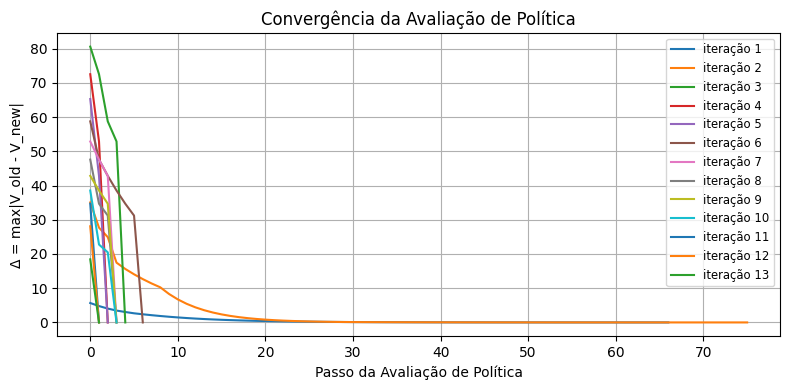

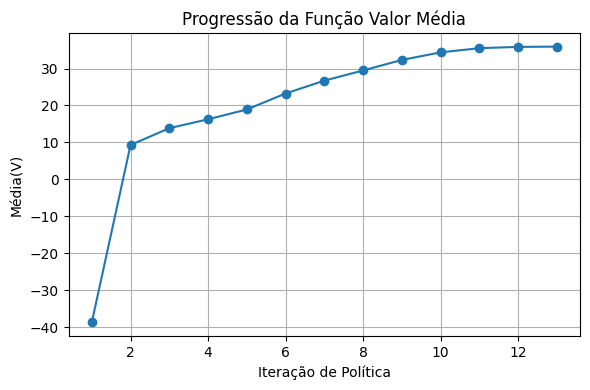

Step 0: State=111, Action=0, Reward=-1, Next State=211
Step 1: State=211, Action=0, Reward=-1, Next State=311
Step 2: State=311, Action=0, Reward=-1, Next State=411
Step 3: State=411, Action=4, Reward=-1, Next State=419
Step 4: State=419, Action=1, Reward=-1, Next State=319
Step 5: State=319, Action=1, Reward=-1, Next State=219
Step 6: State=219, Action=2, Reward=-1, Next State=239
Step 7: State=239, Action=2, Reward=-1, Next State=259
Step 8: State=259, Action=2, Reward=-1, Next State=279
Step 9: State=279, Action=0, Reward=-1, Next State=379
Step 10: State=379, Action=0, Reward=-1, Next State=479
Step 11: State=479, Action=5, Reward=20, Next State=475
finished after 12 steps.

Número de passos para terminar: 12


In [69]:
if __name__ == "__main__":
    taxi = taxi_rl({"gamma": 0.9, "theta": 1.0e-3})
    n_steps_improvment = 0
    policy_stable = False

    while not policy_stable:
        n_steps_improvment += 1
        deltas = taxi.policy_evaluation()
        taxi.eval_deltas.append(deltas)
        policy_stable = taxi.policy_improvement()
        print(f"Iteração {n_steps_improvment:<2} | varreduras={len(deltas):<2} | "
        f"Δ_final={deltas[-1]:.4f}")

    np.save("taxi_policy.npy", taxi.policy)
    # print("Policy After Improvement:", taxi.policy)
    print("politica estável" if policy_stable else "politica não estável")
    print("Número de passos para convergir:", n_steps_improvment)

    # Plota dois gráficos em sequência:
    taxi.plot_policy_iteration_progress(taxi.eval_deltas,
                                   taxi.value_progression)
    
    # taxi.plot_reward()
    n_steps = taxi.run_episodes()
    print("Número de passos para terminar:", n_steps)
    taxi.env.close()
